In [1]:
!pip install transformers albumentations torchvision

Normally after cloning the project template you would have to implement stuff inside `exp1` by your own. We would just provide the project skeleton. With all classes and function defined, but not implemented. For the purpose of this tutorial we implemented all the functions so that you can observe how to use art.

Lets tackle this strong enemy with art framework.

At first, we need to download the data. We highly recommend using huggingface datasets wrapped into Lighntning Data Module. But if you want you can use Torch Datasets and DataLoaders.


In [1]:
%load_ext autoreload
%autoreload 2

import datasets
from art_data import MNISTDataModule
from art.enums import INPUT, TARGET
from art.step.checks import CheckScoreExists, CheckScoreGreaterThan, CheckScoreLessThan

def get_data_module(n_train = 200):
    mnist_data = datasets.load_dataset("mnist")

    mnist_data = mnist_data.rename_columns({"image": INPUT, "label": TARGET})
    mnist_data['train'] = mnist_data['train'].select(range(n_train))

    return MNISTDataModule(mnist_data)

mnist_data_module = get_data_module()

/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/neptune/internal/backends/hosted_client.py:51: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/loggers/neptune.py:51: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


#### Data analysis

TBD in v2.0

#### Baselines

Starting any Machine Learning project it is good to have some baseline for comparison. Here in `ART` we try to encourage you to try at least one of those:
* Ml Baseline - Not for all problems we need Deep Learninr. For tabular data or timeseries there are ML models that you can take off the shelf and obtain very good results. 
* Heuristic Baseline - Sometimes you may have some intuition on how should be data regressed or classified. It is always worth to check how good these are.
* existing solution baseline - If problem is already solved, checking existing solutions and pointing their drawback to improve on is always worth doing.


Another good habbit is to separate your code into many smaller modules, and don't do everything inside one gigantic jupyter notebook. Look inside `baselines.py` file where we have prepared everything for you.

Have you observed plenty of small functions inside each of the class? These will create pipelines of your ArtModule.

e.g `MlBaseline` has functions `parse_data_for_ml` and `baseline_train` that both creates `ml_train_pipeline` that is defined inside art. As you become more familar with `ART` you will be able to create your own pipelines and it's building blocks.

Finally to offer you high level of flexibility we pass data between all stages with use of a dictionary (This will be changed into some better structure in the future).

In [2]:
from art.metric_calculator import MetricCalculator
from torchmetrics import Accuracy
import torch.nn as nn
from art.step.steps import EvaluateBaselines
from art.experiment.Experiment import Experiment

exp = Experiment("exp1")

MetricCalculator.register_metric(Accuracy(task="multiclass", num_classes = 10))
MetricCalculator.register_metric(nn.CrossEntropyLoss(), exception_steps = [EvaluateBaselines])

Already at the first step a lot has happened.
1. We defined experiment - heart of art. later we will add steps that will be performed for this particular experiment
2. We registered some metrics in MetricCalculator - this class performs metric calculation for all models defined by you during every step. The only need you must provide is a consistent format of returned data from different models. You can easily add exceptions - We don't want to calculate loss for the Evaluate Baseline Step. If some metrics are expensive to calculate you add an exception and it won't be calculated. You don't need to modify the code to modify metrics behaviour.

In [3]:
from baselines import MlBaseline, HeuristicBaseline, AlreadyExistingSolutionBaseline
from sklearn.linear_model import LogisticRegression

baselines = [HeuristicBaseline(), MlBaseline(model = LogisticRegression()), AlreadyExistingSolutionBaseline()]
baseline_names = [baseline.name for baseline in baselines]
exp.add_step(
    EvaluateBaselines(
        baselines, mnist_data_module
    ), [CheckScoreExists('Evaluate Baselines', f"check_{name}", name) for name in baseline_names]
)

Here we defined our 3 baselines. You can check how these are structured in `baselines.py` file. Next we create our first step that will consist of their evaluation. We always add new steps in a form: `step to be performd`, `list_of_check_to_be_performed`

In [4]:
#TODO there is a lot of prompt here, discuss if we want tu surpress it
# One solution is logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING) etc.
exp.run_all()

Evaluate Baselines


/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connector

Validation DataLoader 0: 100%|██████████| 625/625 [00:03<00:00, 199.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy-HeuristicBaseline-TRAIN-Evaluate   │                   0.5163999795913696                   │
│                       Baselines                        │                                                        │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the numb

Validation DataLoader 0: 100%|██████████| 625/625 [00:03<00:00, 188.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ MulticlassAccuracy-MlBaseline-TRAIN-Evaluate Baselines │                   0.6563000082969666                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 625/625 [00:05<00:00, 120.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ MulticlassAccuracy-AlreadyExistingSolutionBaseline-TR… │                   0.9883000254631042                   │
│                       Baselines                        │                                                        │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

Allright, a lot has happened. But at the end we have validated three baselines succesfully. We can see, that the Already existing solution is a very strong competitor. If results obtained by these baselines are satisfactory. 

Please visit checkpoints folder - results of this stage is saved here. `In version 2.0 you will be able to see all the results from the dashboard`.

Having baselines we can move on and try to beat them. We will use CNN for this purpose that is defined inside `models.py`. The next step is to validate loss after network initialization. If it is off, we probably messed something up in our pipeline. We have 10 classes, so on average with random initialization loss should be -log(1/10) = 2.31

In [5]:
from models import MNISTModel
from art.step.steps import CheckLossOnInit
from art.step.checks import CheckScoreCloseTo
MetricCalculator.to("cpu")
my_model = MNISTModel()

#TODO need to work how to get this CrossEntropyLoss-MNISTModel-VALIDATION-Check Loss On Init stuff automatically.
exp.add_step(CheckLossOnInit(my_model, mnist_data_module), [CheckScoreCloseTo("Check Loss on Init", "check_loss", "CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init", 2.3, rel_tol=0.1)]) 
exp.run_all()

Check Loss On Init


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 128.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init  │                   13.759095191955566                   │
│ MulticlassAccuracy-MNISTModel-TRAIN-Check Loss On Init │                  0.09000000357627869                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

Exception: Check failed for step: Check Loss On Init

And here we are, something must be wrong in our pipeline - loss is off by big amount. Observe, two things:
1. We didn't perform baselines evaluations again this step is already passed
2. We added a check to our step. We want our loss to be close to 2.3 we failed to provide this result so we obtained an exception. We can't go further until we pass this stage.

Lets discover another feature of art that helps you to debug the code and find problems with your pipeline - Decorators.

In [6]:
import lovely_tensors as lt
from art.visualization_decorators import set_visualization
import logging
lt.monkey_patch()

logging.basicConfig(filename='debug_art.log', encoding='utf-8', level=logging.WARNING)
def first_logging_func(data):
    logging.warning(data)


set_visualization([(my_model, "predict")], first_logging_func)
exp.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Check Loss On Init
Validation DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 113.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init  │                   13.759095191955566                   │
│ MulticlassAccuracy-MNISTModel-TRAIN-Check Loss On Init │                  0.09000000357627869                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

Exception: Check failed for step: Check Loss On Init

You may decorate any function in your pipeline with some any logging function. Here it is simple log, but in practice you can do much, much more, which you will see later. Please visit `debug_art.log` file. Can you spot what is wrong? Yes we do not normalize images to [0,1] range.


In [7]:
exp.steps[1].model.normalize_img = True
exp.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Check Loss On Init
Validation DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 119.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init  │                   2.3126115798950195                   │
│ MulticlassAccuracy-MNISTModel-TRAIN-Check Loss On Init │                  0.10499999672174454                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

And we've done it! We gained a little more confidence to our pipeline. Let's move further. Next step is to overfit just single batch. If you can't do this there is for sure something wrong. From now procedure for everything else is very similar. So we import next step and add it to our experiment with appropriate check

In [8]:
from art.step.steps import OverfitOneBatch
overfit_batch_step = OverfitOneBatch(MNISTModel(), mnist_data_module)
exp.add_step(overfit_batch_step, [CheckScoreLessThan("Overfit One Batch", "check_loss", "loss_at_the_end", 0.01)])
exp.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many 

Overfit One Batch
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.83it/s, v_num=16] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.91it/s, v_num=16]
{'MulticlassAccuracy-MNISTModel-TRAIN-Overfit One Batch': tensor 1.000, 'CrossEntropyLoss-MNISTModel-TRAIN-Overfit One Batch': tensor 0.536}
Loss at the end of overfitting: 0.5355706214904785


Exception: Check failed for step: Overfit One Batch

Oh no... we can't overfit. It this an issue with model? Maybe but at first let's see another powerful usecase of art. We will debug the prediction dynamics too see how our model is evolving. We will calculate average logit value for all images that should be classified as 1. For this purpose we create a class with memory and make it callable, later we decorate our's model prediction function and casually run the experiment.

In [9]:
class EvolutionSaver:
    def __init__(self):
        self.logits = []
        self.time = 0

    def __call__(self, data):
        targets = data['target'] == 1
        logits = data['prediction']
        
        wanted_logits = logits[targets].mean(dim=0)
        for i, logit in enumerate(wanted_logits):
            self.logits.append({
                "time": self.time,
                "logit": logit.item(),
                "class": i
            })

        self.time += 1    

    def visualize(self):
        import pandas as pd
        import matplotlib.pyplot as plt
        df = pd.DataFrame(self.logits)
        df = df.pivot(index='time', columns='class', values='logit')
        df.plot()
        plt.show()

my_model = MNISTModel()
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver)
overfit_batch_step.model = my_model # TODO THIS IS DONE TO RESET WEIGHTS (THIS SHOULD BE SOMEHOW DONE IN A BETTER WAY)
exp.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Overfit One Batch
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 85.48it/s, v_num=17] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.30it/s, v_num=17]
{'MulticlassAccuracy-MNISTModel-TRAIN-Overfit One Batch': tensor 1.000, 'CrossEntropyLoss-MNISTModel-TRAIN-Overfit One Batch': tensor 0.767}
Loss at the end of overfitting: 0.7669425010681152


Exception: Check failed for step: Overfit One Batch

Experiment fails, we now that. But what about the visualization?

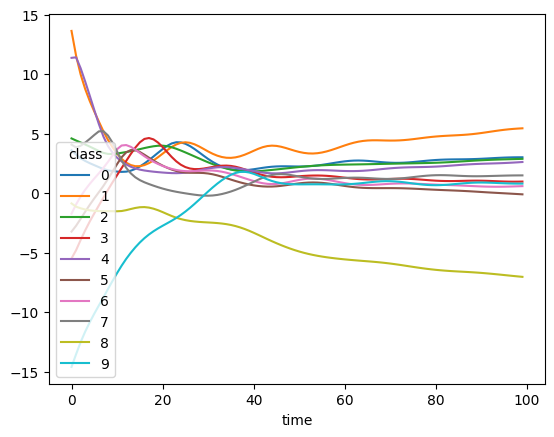

In [10]:
evolution_saver.visualize()

So, as you can see we move in correct direction 1 has biggest logist very soons but the difference is not big enough yet - Probably we should just wait a little bit longer. Moreover, we see how powerful decorators can be. This helps us make our code more modular and fulfill Open-Closed principle.

We can solve our problem in two ways:
* Either increase learning rate.
* Or train for longer.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many 

Overfit One Batch
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 52.72it/s, v_num=18] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 36.32it/s, v_num=18]
{'MulticlassAccuracy-MNISTModel-TRAIN-Overfit One Batch': tensor 1.000, 'CrossEntropyLoss-MNISTModel-TRAIN-Overfit One Batch': tensor 0.001}
Loss at the end of overfitting: 0.001038111629895866


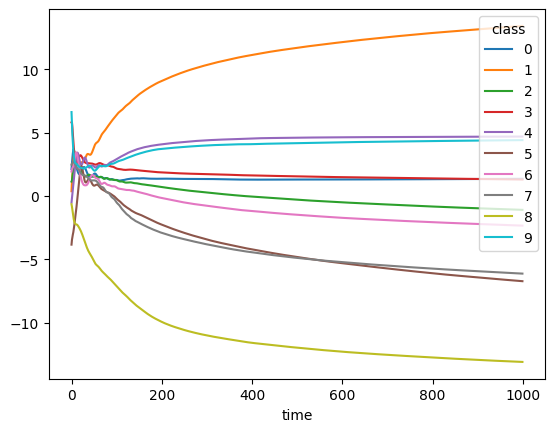

In [11]:
my_model = MNISTModel()
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver) # TODO ALSO THIS OBJECT THAT SAVE STATE SHOULD BE RESETTABLE
overfit_batch_step.model = my_model
overfit_batch_step.number_of_steps = 1000 # TODO THIS SHOULD BE DONE IN A BETTER WAY 
exp.run_all()
evolution_saver.visualize()

Nice! At overfitting process we'd recommend not to play with learning rate and stick with default value. It is better to just wait for a little bit longer. Now another Step can be taken. Overfitting entire training set. This is also very important as this somehow approximates our best possible score that can be achieved. If it is much below our expected result this again may indicate problems.

In [12]:
from art.step.steps import Overfit
my_model = MNISTModel() # TODO models shouldn't be created on and on 
exp = Experiment("exp1")
exp.add_step(Overfit(my_model, mnist_data_module, max_epochs=50), [CheckScoreGreaterThan("Overfit", "check_loss", "MulticlassAccuracy-MNISTModel-TRAIN-Overfit", 0.90)])
exp.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of t

Overfit
Epoch 0:   8%|▊         | 1/13 [00:00<00:00, 91.18it/s, v_num=19]

Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 77.55it/s, v_num=19] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 74.42it/s, v_num=19]


/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 107.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃               Validate metric               ┃                DataLoader 0                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Overfit  │             0.5043187141418457              │
│ MulticlassAccuracy-MNISTModel-TRAIN-Overfit │             0.9049999713897705              │
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

Validation DataLoader 0: 100%|██████████| 625/625 [00:05<00:00, 118.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Validate metric                  ┃                   DataLoader 0                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-VALIDATION-Overfit  │                1.2276248931884766                │
│ MulticlassAccuracy-MNISTModel-VALIDATION-Overfit │                0.5688999891281128                │
└──────────────────────────────────────────────────┴──────────────────────────────────────────────────┘

Nice, We were able to pass the next stage in the first try. Hopefully you see another challenge that we have to face. We are able to obtain nice accuracy on the training stage. But on the validation it decreases by very much. We are overfitting the training set. For this tutorial training set was chosen to be very small so this problem was expected. But now let's try to pass the finals step of this tutorial, namely regularization. When regularizing the model you should start from the most powerful regularization technique and go to weaker. Here we will use:

1. getting more data - definitely one of the most powerful techniques. If possible always prefer this one.
2. augmentations - also very strong one

When applying augmentations to the images it is crucial to verify how do they influence the image. We again can use our decoration possibilities. *Under the hood `Regularize` class runs turn_on_regularization of ArtModule and the DataModule you use*.

You can see what we input to the network by checking `augmentations_i.png` files.

In [13]:
from torchvision.utils import save_image
from art.step.steps import Regularize

class BatchSaver:
    def __init__(self):
        self.time = 0

    def __call__(self, data):
        # We 
        if self.time < 10:
            save_image(data['input'], f'augmentations_{self.time}.png')
        self.time +=1
    

my_model = MNISTModel() # TODO models shouldn't be created on and on
mnist_data_module = get_data_module(n_train=2000) 
set_visualization([(my_model, "predict")], BatchSaver())
exp.add_step(Regularize(my_model, mnist_data_module), [CheckScoreGreaterThan("Regularize", "check_loss", "MulticlassAccuracy-MNISTModel-VALIDATION-Regularize", 0.80)])
exp.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Regularize
                                                                            

/home/sebastian/mambaforge/envs/art/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


Epoch 49: 100%|██████████| 125/125 [00:09<00:00, 13.11it/s, v_num=20]

`Trainer.fit` stopped: `max_epochs=50` reached.


Validation DataLoader 0: 100%|██████████| 625/625 [00:05<00:00, 120.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Validate metric                   ┃                    DataLoader 0                     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-VALIDATION-Regularize  │                 0.3788207769393921                  │
│ MulticlassAccuracy-MNISTModel-VALIDATION-Regularize │                 0.8889999985694885                  │
└─────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Here you are! Hopefully, now you have incentive to try ART for your next data science project.